In [2]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to c:\users\gauta\appdata\local\temp\pip-req-build-h76cud10
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\gauta\AppData\Local\Temp\pip-req-build-h76cud10'


In [3]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, RepeatVector, Dot, Activation, Lambda, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import tensorflow as tf

In [5]:
# Directories for input/output
INPUT_DIR = r'C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Data'
OUTPUT_DIR = r'C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Results'

if not os.path.exists(INPUT_DIR):
    raise FileNotFoundError("Input directory not found")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [6]:
# Load CLIP model and preprocessing pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Image Preprocessing
clip_preprocess = Compose([
    Resize((224, 224)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

In [23]:
import os
from PIL import Image
from tqdm import tqdm
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import clip

# Initialize CLIP model and preprocessing pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Path to the images folder
img_dir = os.path.join(INPUT_DIR, 'Images')

# Valid image extensions
valid_extensions = {".jpg", ".jpeg", ".png"}

# Initialize dictionary to store features
clip_features = {}

# Process images
for img_name in tqdm(os.listdir(img_dir), desc="Processing Images"):
    img_path = os.path.join(img_dir, img_name)

    # Skip non-image files
    if not os.path.splitext(img_name)[1].lower() in valid_extensions:
        print(f"Skipping non-image file: {img_name}")
        continue

    try:
        # Open and preprocess the image
        img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        # Extract features using CLIP
        with torch.no_grad():
            img_feature = clip_model.encode_image(img_tensor).cpu().numpy()

        # Use filename without extension as the ID
        img_id = os.path.splitext(img_name)[0]
        clip_features[img_id] = img_feature

    except Exception as e:
        print(f"Error processing {img_name}: {e}")



Processing Images: 100%|██████████| 31783/31783 [1:34:14<00:00,  5.62it/s]


In [24]:
# Save image features
with open(os.path.join(OUTPUT_DIR, "clip_features.pkl"), "wb") as f:
    pickle.dump(clip_features, f)

In [7]:
# Load image features
with open(os.path.join(OUTPUT_DIR, "clip_features.pkl"), "rb") as f:
    loaded_features = pickle.load(f)

In [8]:
# Captions Mapping
image_to_caption_mapping = defaultdict(list)
captions_doc_path = os.path.join(INPUT_DIR, 'captions.txt')

In [9]:
import os
from collections import defaultdict
from tqdm import tqdm
import csv

# Initialize counters
total_captions = 0
total_images = 0

# Read and process the captions file
try:
    with open(captions_doc_path, 'r', encoding='utf-8') as f:
        # Use csv.reader to handle quotes and commas
        reader = csv.reader(f)

        # Skip header row
        next(reader, None)

        for row in tqdm(reader, desc="Processing Captions"):
            if len(row) < 2:  # Skip malformed rows
                continue

            # Extract image ID and caption
            image_name = row[0].strip()  # First column: Image filename
            caption_text = row[1].strip()  # Second column: Caption text

            # Remove file extension from image name
            image_id = image_name.split('.')[0]

            # Append caption to the mapping
            image_to_caption_mapping[image_id].append(caption_text)
            
            total_captions += 1
            
        total_images = len(image_to_caption_mapping)

except Exception as e:
    print(f"Error processing file: {e}")

# # Example: Print some processed captions
# for image_id, captions in list(image_to_caption_mapping.items())[:5]:
#     print(f"Image ID: {image_id}")
#     for caption in captions:
#         print(f"Caption: {caption}")

print(f"Total captions: {total_captions}")
print(f"Total images: {total_images}")

Processing Captions: 158915it [00:00, 492698.15it/s]

Total captions: 158915
Total images: 31783


In [10]:
print(len(image_to_caption_mapping))

31783


In [11]:
# Preprocess Captions
def preprocess_captions(mapping):
    for key, captions in tqdm(mapping.items()):
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = ''.join(char for char in caption if char.isalnum() or char.isspace())
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

preprocess_captions(image_to_caption_mapping)

100%|██████████| 31783/31783 [00:01<00:00, 27752.75it/s]


In [12]:

# Tokenizer
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Max Caption Length
max_caption_length = max(len(caption.split()) for caption in all_captions)

In [13]:
print("Vocabulary Size:", vocab_size)
print("Max Caption Length:", max_caption_length)

Vocabulary Size: 19977
Max Caption Length: 74


In [21]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare data for a single image ID
def prepare_data(image_id, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size):
    X1, X2, y = [], [], []
    captions = image_to_caption_mapping[image_id]
    for caption in captions:
        # Convert caption to sequence
        caption_seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(caption_seq)):
            # Input sequence: all words up to the current one
            in_seq = pad_sequences([caption_seq[:i]], maxlen=max_caption_length)[0]
            # Output sequence: the next word (one-hot encoded)
            out_seq = to_categorical([caption_seq[i]], num_classes=vocab_size)[0]

            # Image features, input sequence, and output word
            X1.append(features[image_id].flatten())  # Flattened CLIP features
            X2.append(in_seq)
            y.append(out_seq)

    return X1, X2, y


# Data generator for multiple image IDs
def data_generator(image_ids, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for image_id in image_ids:
            # Prepare data for each image
            X1_temp, X2_temp, y_temp = prepare_data(image_id, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size)
            X1.extend(X1_temp)
            X2.extend(X2_temp)
            y.extend(y_temp)

            # Yield a batch if size matches
            while len(X1) >= batch_size:
                yield (np.array(X1[:batch_size]), np.array(X2[:batch_size])), np.array(y[:batch_size])
                X1 = X1[batch_size:]
                X2 = X2[batch_size:]
                y = y[batch_size:]


In [22]:
# Define the Model
inputs1 = Input(shape=(512,), name="image_features")  # CLIP features
fe1 = Dense(256, activation='relu', name="feature_dense")(inputs1)
fe2 = RepeatVector(max_caption_length, name="repeat_features")(fe1)

inputs2 = Input(shape=(max_caption_length,), name="caption_input")
se1 = Embedding(vocab_size, 256, mask_zero=True, name="embedding_layer")(inputs2)
se2 = LSTM(256, return_sequences=True, name="sequence_lstm")(se1)

attention = Dot(axes=[2, 2], name="attention_dot")([fe2, se2])
attention_scores = Activation('softmax', name="attention_scores")(attention)

# Apply attention
attention_context = Lambda(
    lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]),
    output_shape=lambda input_shapes: (input_shapes[0][0], input_shapes[0][1], 256),
    name="attention_context"
)([attention_scores, se2])

context_vector = Lambda(
    lambda x: tf.reduce_sum(x, axis=1),
    output_shape=lambda input_shape: (input_shape[0], input_shape[2]),
    name="context_vector"
)(attention_context)

decoder_input = concatenate([context_vector, fe1], name="decoder_input")
decoder1 = Dense(256, activation='relu', name="decoder_dense")(decoder_input)
outputs = Dense(vocab_size, activation='softmax', name="output_layer")(decoder1)

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_dense       │ (None, 256)       │    131,328 │ image_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 74, 256)   │  5,114,112 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 74)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_features     │ (None, 74, 256)   │          0 │ feature_dense[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_lstm       │ (None, 74, 256)   │    525,312 │ embedding_layer[… │
│ (LSTM)              │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dot (Dot) │ (None, 74, 74)    │          0 │ repeat_features[… │
│                     │                   │            │ sequence_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_scores    │ (None, 74, 74)    │          0 │ attention_dot[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_context   │ (None, 74, 256)   │          0 │ attention_scores… │
│ (Lambda)            │                   │            │ sequence_lstm[0]… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 256)       │          0 │ attention_contex… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 512)       │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ feature_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 256)       │    131,328 │ decoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 19977)     │  5,134,089 │ decoder_dense[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,036,169 (42.10 MB)

 Trainable params: 11,036,169 (42.10 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.utils import plot_model

In [49]:
# Visualize the model
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Filter out image IDs that are missing features
valid_image_ids = [image_id for image_id in image_to_caption_mapping.keys() if image_id in loaded_features]

# Split valid image IDs into training and testing sets
train, test = train_test_split(valid_image_ids, test_size=0.1, random_state=42)

# Log the number of valid images
print(f"Total valid images: {len(valid_image_ids)}")
print(f"Training images: {len(train)}, Testing images: {len(test)}")


Total valid images: 31783
Training images: 28604, Testing images: 3179


Epoch 1/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - loss: 6.6223
Epoch 1: val_loss improved from inf to 6.00955, saving model to C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Results\best_model.keras
894/894 ━━━━━━━━━━━━━━━━━━━━ 725s 807ms/step - loss: 6.6217 - val_loss: 6.0096 - learning_rate: 0.0010
Epoch 2/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - loss: 5.5233
Epoch 2: val_loss improved from 6.00955 to 5.12720, saving model to C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Results\best_model.keras
894/894 ━━━━━━━━━━━━━━━━━━━━ 789s 882ms/step - loss: 5.5232 - val_loss: 5.1272 - learning_rate: 0.0010
Epoch 3/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - loss: 5.3657
Epoch 3: val_loss did not improve from 5.12720
894/894 ━━━━━━━━━━━━━━━━━━━━ 722s 808ms/step - loss: 5.3657 - val_loss: 5.4605 - learning_rate: 0.0010
Epoch 4/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 5.1081
Epoch 4: val_loss did not improve from 5.12720
894/894 ━

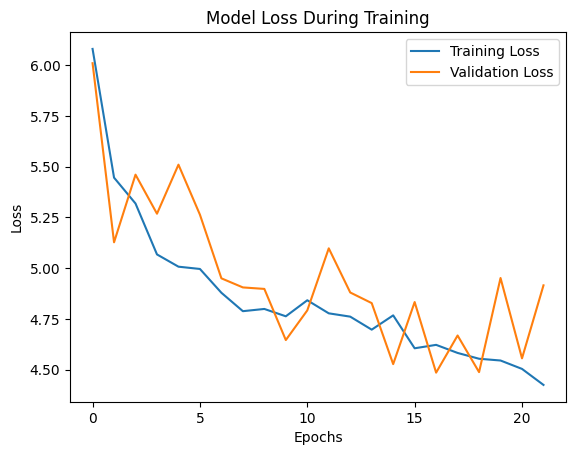

In [52]:
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set training parameters
epochs = 50
batch_size = 32

# Calculate steps per epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),  # Stop training when validation loss stops improving
    ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),  # Save the best model during training
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )  # Reduce learning rate when validation loss plateaus
]

# Set up data generators
train_generator = data_generator(
    train, image_to_caption_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size
)
test_generator = data_generator(
    test, image_to_caption_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save(os.path.join(OUTPUT_DIR, 'clip_model.keras'))

# Plot training history (optional)                                                                                                                                             
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
plt.show()


In [18]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load the model with unsafe deserialization enabled
model = load_model(
    os.path.join(OUTPUT_DIR, 'clip_model.keras'),
    custom_objects={
        'tf': tf,
    },
    compile=True,
    safe_mode=False  # Allow deserialization of Lambda layers
)


c:\Users\gauta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'attention_context' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [23]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm

def get_word_from_index(index, tokenizer):
    """Retrieve a word from the tokenizer's word_index based on its index."""
    return tokenizer.index_word.get(index, None)

def predict_caption(model, image_features, tokenizer, max_caption_length):
    """Generate a caption for an image using the trained model."""
    caption = ['startseq']

    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break

        # Append the predicted word to the caption
        caption.append(predicted_word)

    # Return the caption excluding the start sequence tag
    return ' '.join(caption[1:])

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for image_id in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_caption_mapping[image_id]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(
        model,
        loaded_features[image_id].reshape(1, -1),  # Ensure the feature shape matches the model input
        tokenizer,
        max_caption_length
    )

    # Append the actual and predicted captions to the lists
    actual_captions_list.append([caption.split() for caption in actual_captions])  # Split into words
    predicted_captions_list.append(predicted_caption.split())  # Split into words

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25)))


  0%|          | 0/3179 [00:00<?, ?it/s]

c:\Users\gauta\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\gauta\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\gauta\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

BLEU-1: 0.000064
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


In [26]:
import matplotlib.pyplot as plt

In [27]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_caption_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq girl is on rollerskates talking on her cellphone standing in parking lot endseq
startseq trendy girl talking on her cellphone while gliding slowly down the street endseq
startseq young adult wearing rollerblades holding cellular phone to her ear endseq
startseq there is young girl on her cellphone while skating endseq
startseq woman talking on cellphone and wearing rollerskates endseq
--------------------Predicted--------------------
cropping cropping protruding sleeding claps claps nonmoving autograph autograph autograph goofy autograph autograph autograph claps autograph claps autograph claps autograph claps autograph claps autograph autograph claps claps autograph autograph claps autograph claps autograph claps autograph autograph claps autograph claps autograph claps autograph autograph claps autograph claps autograph claps autograph autograph claps autograph claps autograph claps autograph autograph claps autograph claps au

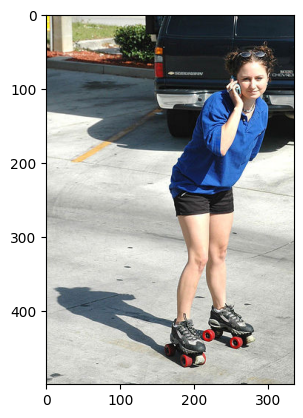

In [28]:
generate_caption("10010052.jpg")